In [7]:
import numpy as np

In [204]:
class FastGradientDescent:
    def __init__(self, gamma, epsilon, n):
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n
        self.inf = 1e+6
        self.small = 1e-16
        self.l = 1 / gamma

        self.a = self.alpha = 0
        
        self.u_lambda = self.u_mu = np.ones([n])
        self.y_lambda = self.y_mu = np.zeros(n)
        self.x_lambda = self.x_mu = np.ones([n])
        
        self.x_0 = np.ones([n, n]) / (n**2)

    
    def x_hat(self, c, lambda_y, mu_y):
        a_min = np.min(self.gamma + c + lambda_y.repeat(self.n).reshape(-1, self.n) + mu_y.repeat(self.n).reshape(-1, self.n).T)
        exp_ = -(self.gamma + c + lambda_y.repeat(self.n).reshape(-1, self.n) + mu_y.repeat(self.n).reshape(-1, self.n).T - a_min) / self.gamma
        exp_[exp_ < -100] = -100
        x_hat = self.x_0 * np.exp(
            exp_
        )
        return x_hat / x_hat.sum()
    
    def _new_alpha(self):
        return 1 / (2 * self.l) + np.sqrt(1 / (4 * (self.l**2)) + self.alpha**2)
    
    def _new_a(self, new_alpha):
        return self.a + new_alpha
    
    def _new_y(self, u_lambda, u_mu, x_lambda, x_mu):
        new_alpha = self._new_alpha()
        new_a = self._new_a(new_alpha)
        
        return (new_alpha * u_lambda + self.a * x_lambda) / new_a,\
               (new_alpha * u_mu     + self.a * x_mu)     / new_a
    
    def _new_u(self, c, u_lambda, u_mu, y_lambda_new, y_mu_new, p, q):
        x_hat = self.x_hat(c, y_lambda_new, y_mu_new)
        new_alpha = self._new_alpha()
        
        return u_lambda - new_alpha * (p - x_hat.sum(1)),\
               u_mu     - new_alpha * (q - x_hat.sum(0))
    
    def _new_x(self, u_lambda_new, u_mu_new, x_lambda, x_mu, p, q):
        new_alpha = self._new_alpha()
        new_a = self._new_a(new_alpha)
        
        return (new_alpha * u_lambda_new + self.a * x_lambda) / new_a,\
               (new_alpha * u_mu_new     + self.a * x_mu)     / new_a
    
    def f(self, c, x):
        return (c * x).sum() + self.gamma * ((x + self.small) * np.log((x + self.small) / self.x_0)).sum()
    
    def phi(self, c, p, q, lambda_x, mu_x):
        a_min = np.min(self.gamma + c + lambda_x.repeat(self.n).reshape(-1, self.n) + mu_x.repeat(self.n).reshape(-1, self.n).T)
        exp_ = -(self.gamma + c + lambda_x.repeat(self.n).reshape(-1, self.n) + mu_x.repeat(self.n).reshape(-1, self.n).T - a_min) / self.gamma
        exp_[exp_ < -100] = -100
        return -(lambda_x * p).sum() - (mu_x * q).sum() - \
                self.gamma * np.log(1/np.e * (self.x_0 * np.exp(
                    exp_
                )).sum())
    
    def deviation_p_q(self, x, p, q):
        return np.sqrt(np.sum((x.sum(1) - p)**2) + np.sum((x.sum(0) - q)**2))
    
    def fit(self, c, p, q):
        k = 0
        
        while True:
            y_lambda_new, y_mu_new = self._new_y(self.u_lambda, self.u_mu, self.x_lambda, self.x_mu)
            _c = 1 / (2 * self.n) * (np.sum(y_mu_new) - np.sum(y_lambda_new))
            y_lambda_new += _c
            y_mu_new -= _c
            
            u_lambda_new, u_mu_new = self._new_u(c, self.u_lambda, self.u_mu, y_lambda_new, y_mu_new, p, q)
            x_lambda_new, x_mu_new = self._new_x(u_lambda_new, u_mu_new, self.x_lambda, self.x_mu, p, q)
            
            self.y_lambda, self.y_mu = (y_lambda_new, y_mu_new)
            self.u_lambda, self.u_mu = (u_lambda_new, u_mu_new)
            self.x_lambda, self.x_mu = (x_lambda_new, x_mu_new)
            
            self.alpha = self._new_alpha()
            self.a     = self._new_a(self.alpha)
            
            x_wave = self.x_hat(c, self.y_lambda, self.y_mu)
            r = np.sqrt((self.x_lambda**2).sum() + (self.x_mu**2).sum())
            epsilon_wave = self.epsilon / r
            
            criteria_a = self.deviation_p_q(x_wave, p, q) <= epsilon_wave
            criteria_b = self.f(c, x_wave) - self.phi(c, p, q, self.x_lambda, self.x_mu) <= self.epsilon
            
            if k % 1000 == 0:
                print(f'iteration {k}:   criteria 1 = {round(self.deviation_p_q(x_wave, p, q), 7)}, ' + \
                                       f'criteria 2 = {round(self.f(c, x_wave) - self.phi(c, p, q, self.x_lambda, self.x_mu), 7)}')
    
            if criteria_a and criteria_b:
                return x_wave, k
            
            k += 1

In [117]:
def sample_batch(n):
    c = np.random.uniform(0, 10, size=[n, n])
    p = np.random.dirichlet(np.ones(n), size=1).ravel()
    q = np.random.dirichlet(np.ones(n), size=1).ravel()
    return c, p, q

In [118]:
n = 40
c, p, q = sample_batch(n)
x, k = FastGradientDescent(gamma=0.005, epsilon=1e-2, n=n).fit(c, p, q)

iteration 0:   criteria 1 = 0.1801431, criteria 2 = -0.0101602
iteration 10:   criteria 1 = 0.0878568, criteria 2 = -0.0114118
iteration 20:   criteria 1 = 0.0285585, criteria 2 = -0.0103486
iteration 30:   criteria 1 = 0.0119639, criteria 2 = -0.0101349
iteration 40:   criteria 1 = 0.0072328, criteria 2 = -0.0100197
iteration 50:   criteria 1 = 0.0046267, criteria 2 = -0.0099963
iteration 60:   criteria 1 = 0.0029758, criteria 2 = -0.0100259
iteration 70:   criteria 1 = 0.0021981, criteria 2 = -0.0100149
iteration 80:   criteria 1 = 0.0015603, criteria 2 = -0.0100016
iteration 90:   criteria 1 = 0.0014147, criteria 2 = -0.0099938
iteration 100:   criteria 1 = 0.0011313, criteria 2 = -0.0099856


In [119]:
import sys
sys.path.append("experiments/")

In [130]:
from lib import Experiments

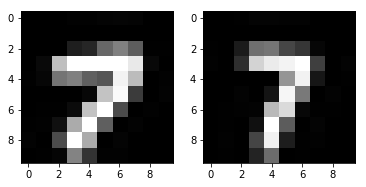

In [145]:
c_, p_, q_ = Experiments.load_data('experiments/test_data/1.png', 'experiments/test_data/2.png', show=True, size=10)
n = p_.shape[0]

In [205]:
x, k = FastGradientDescent(gamma=0.005, epsilon=1e-2, n=n).fit(c_, p_, q_)

iteration 0:   criteria 1 = 0.2585712, criteria 2 = 1.9941681
iteration 1000:   criteria 1 = 0.0230392, criteria 2 = 1.8681706
iteration 2000:   criteria 1 = 0.0118222, criteria 2 = 1.95115
iteration 3000:   criteria 1 = 0.0126735, criteria 2 = 1.9537534
iteration 4000:   criteria 1 = 0.0101017, criteria 2 = 1.9772364
iteration 5000:   criteria 1 = 0.0047377, criteria 2 = 1.9687172
iteration 6000:   criteria 1 = 0.0033618, criteria 2 = 1.9742767
iteration 7000:   criteria 1 = 0.003809, criteria 2 = 1.9764719
iteration 8000:   criteria 1 = 0.0021773, criteria 2 = 1.970753
iteration 9000:   criteria 1 = 0.0022237, criteria 2 = 1.9705364
iteration 10000:   criteria 1 = 0.00172, criteria 2 = 1.9727311
iteration 11000:   criteria 1 = 0.0019684, criteria 2 = 1.9735374
iteration 12000:   criteria 1 = 0.0024502, criteria 2 = 1.9758583
iteration 13000:   criteria 1 = 0.001451, criteria 2 = 1.9735647
iteration 14000:   criteria 1 = 0.0014467, criteria 2 = 1.9727075
iteration 15000:   criteria 1 

KeyboardInterrupt: 

In [ ]:
x